In [2]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.linear_model import LinearRegression
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import skforecast
import lightgbm
from xgboost import XGBRegressor
import xgboost
from numpy.random import Generator, PCG64

%load_ext pyinstrument

In [2]:
print(skforecast.__version__)
print(lightgbm.__version__)
print(xgboost.__version__)

0.8.0
3.3.5
1.7.5


In [3]:
data = pd.read_csv("data.csv")
data.date_time = pd.to_datetime(data.date_time)
data= data.set_index('date_time')
data = data.asfreq('H')

# Split train-validation-test
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123, n_estimators=500),
                 lags = 24
             )

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, n_estimators=500),
                 lags = 24
             )


# forecaster = ForecasterAutoreg(
#                  regressor = Ridge(random_state=123),
#                  lags = 24
#              )

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


In [4]:
%%timeit
forecaster.fit(y= data.loc[:end_validation, 'users'],)

424 ms ± 57.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%pyinstrument
forecaster.predict(1000)

2012-09-01 00:00:00    122.791461
2012-09-01 01:00:00     79.588384
2012-09-01 02:00:00     44.759529
2012-09-01 03:00:00     21.803527
2012-09-01 04:00:00      5.661290
                          ...    
2012-10-12 11:00:00    151.444638
2012-10-12 12:00:00    105.380524
2012-10-12 13:00:00     82.609657
2012-10-12 14:00:00     62.766092
2012-10-12 15:00:00     45.457549
Freq: H, Name: pred, Length: 1000, dtype: float64

_     ._   __/__   _ _  _  _ _/_   Recorded: 13:12:37  Samples:  210
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.219     CPU time: 2.422
/   _/                      v4.4.0

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"a2c2bdfa-fb8c-4d3b-a809-80a11f966b89" --shell=9007 --transport="tcp" --iopub=9009 --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-123601W7mUPu7yPgu.json

0.218 <module>  ..\..\..\AppData\Local\Temp\ipykernel_6992\3309640099.py:1
`- 0.218 ForecasterAutoreg.predict  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:594
      [124 frames hidden]  skforecast, lightgbm, numpy, ctypes, ...
         0.110 inner_predict  lightgbm\basic.py:896

In [7]:
%%timeit -r 4 -n 1000

X, y = forecaster.create_train_X_y(data.loc[:, 'users'])

2.25 ms ± 152 µs per loop (mean ± std. dev. of 4 runs, 1,000 loops each)


In [10]:
X, y = forecaster.create_train_X_y(data.loc[:, 'users'])
y.dtypes

dtype('float64')

In [11]:
%%pyinstrument
_ = backtesting_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'], # Train and validation data
                   steps              = 36,
                   refit              = True,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train)
)

c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\skforecast\model_selection\model_selection.py:448: LongTrainingWarning: The forecaster will be fit 102 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

_     ._   __/__   _ _  _  _ _/_   Recorded: 13:16:39  Samples:  30005
 /_//_/// /_\ / //_// / //_'/ //     Duration: 45.225    CPU time: 682.047
/   _/                      v4.4.0

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"a2c2bdfa-fb8c-4d3b-a809-80a11f966b89" --shell=9007 --transport="tcp" --iopub=9009 --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-123601W7mUPu7yPgu.json

45.225 <module>  ..\..\..\AppData\Local\Temp\ipykernel_6992\1222812153.py:1
`- 45.224 backtesting_forecaster  skforecast\model_selection\model_selection.py:705
      [1713 frames hidden]  skforecast, lightgbm, <built-in>, cty...
         34.079 Booster.update  lightgbm\basic.py:2964

In [12]:
%%pyinstrument
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'], # Train and validation data
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train), # Model is trained with training data
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 14885.139467537147



_     ._   __/__   _ _  _  _ _/_   Recorded: 13:23:53  Samples:  9322
 /_//_/// /_\ / //_// / //_'/ //     Duration: 10.302    CPU time: 151.141
/   _/                      v4.4.0

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"a2c2bdfa-fb8c-4d3b-a809-80a11f966b89" --shell=9007 --transport="tcp" --iopub=9009 --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-123601W7mUPu7yPgu.json

10.301 <module>  ..\..\..\AppData\Local\Temp\ipykernel_6992\244285910.py:1
`- 10.300 grid_search_forecaster  skforecast\model_selection\model_selection.py:897
      [2035 frames hidden]  skforecast, lightgbm, numpy, ctypes, ...

In [ ]:
%%pyinstrument
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [1000],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'], # Train and validation data
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train), # Model is trained with training data
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
  Backtesting metric: 13605.107261105946



_     ._   __/__   _ _  _  _ _/_   Recorded: 20:43:25  Samples:  83963
 /_//_/// /_\ / //_// / //_'/ //     Duration: 305.457   CPU time: 2213.812
/   _/                      v4.4.0

Program: c:\anaconda\envs\skforecast_p10\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9011 --control=9009 --hb=9008 --Session.signature_scheme="hmac-sha256" --Session.key=b"79054074-9ffb-49a7-be03-ab5b979ffe68" --shell=9010 --transport="tcp" --iopub=9012 --f="c:\Users\Joaquín Amat\AppData\Roaming\jupyter\runtime\kernel-v2-14940Ku7HThYIxh6w.json"

305.457 <module>  ..\..\..\..\Local\Temp\ipykernel_3420\558181007.py:1
`- 305.456 grid_search_forecaster  skforecast\model_selection\model_selection.py:897
      [3440 frames hidden]  skforecast, xgboost, <built-in>, typi...
         220.991 Booster.update  xgboost\core.py:1897

In [13]:
%%pyinstrument


forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123, n_estimators=500),
                 lags = 24
             )

             
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'], # Train and validation data
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train), # Model is trained with training data
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 13132.573900322006



_     ._   __/__   _ _  _  _ _/_   Recorded: 13:27:50  Samples:  94621
 /_//_/// /_\ / //_// / //_'/ //     Duration: 159.254   CPU time: 2196.750
/   _/                      v4.4.0

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"a2c2bdfa-fb8c-4d3b-a809-80a11f966b89" --shell=9007 --transport="tcp" --iopub=9009 --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-123601W7mUPu7yPgu.json

159.256 <module>  ..\..\..\AppData\Local\Temp\ipykernel_6992\4273443021.py:1
`- 159.255 grid_search_forecaster  skforecast\model_selection\model_selection.py:897
      [3396 frames hidden]  skforecast, xgboost, sklearn, inspect...
         66.493 Booster.update  xgboost\core.py:1897

In [9]:
%%pyinstrument


forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, n_estimators=500),
                 lags = 24
             )

             
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'], # Train and validation data
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train), # Model is trained with training data
                   fixed_train_size   = False,
                   return_best        = False,
                   verbose            = False
               )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:22:25  Samples:  29865
 /_//_/// /_\ / //_// / //_'/ //     Duration: 38.584    CPU time: 288.438
/   _/                      v4.4.0

Program: c:\anaconda\envs\skforecast_p10\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9018 --control=9016 --hb=9015 --Session.signature_scheme="hmac-sha256" --Session.key=b"05c70e31-3bbd-43ce-9066-1e274077d55e" --shell=9017 --transport="tcp" --iopub=9019 --f="c:\Users\Joaquín Amat\AppData\Roaming\jupyter\runtime\kernel-v2-14940J54UPRmcSMTp.json"

38.586 <module>  ..\..\..\..\Local\Temp\ipykernel_20012\1524724431.py:1
`- 38.584 grid_search_forecaster  skforecast\model_selection\model_selection.py:897
      [2944 frames hidden]  skforecast, lightgbm, numpy, ctypes, ...
         11.013 Booster.update  lightgbm\basic.py:2964

In [8]:
%%pyinstrument


forecaster = ForecasterAutoreg(
                 regressor = Ridge(random_state=123,),
                 lags = 24
             )

             
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
 'alpha': [1,0.1,0.01,0.001,0.0001,0],
 "fit_intercept": [True, False],
 "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
 }

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'], # Train and validation data
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train), # Model is trained with training data
                   fixed_train_size   = False,
                   return_best        = False,
                   verbose            = False
               )

Number of models compared: 144.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/72 [00:00<?, ?it/s]

params grid:   0%|          | 0/72 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'alpha': 0, 'fit_intercept': False, 'solver': 'sag'}
  Backtesting metric: 15698.22355206917



_     ._   __/__   _ _  _  _ _/_   Recorded: 22:19:20  Samples:  53222
 /_//_/// /_\ / //_// / //_'/ //     Duration: 60.514    CPU time: 62.328
/   _/                      v4.4.0

Program: c:\anaconda\envs\skforecast_p10\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9018 --control=9016 --hb=9015 --Session.signature_scheme="hmac-sha256" --Session.key=b"05c70e31-3bbd-43ce-9066-1e274077d55e" --shell=9017 --transport="tcp" --iopub=9019 --f="c:\Users\Joaquín Amat\AppData\Roaming\jupyter\runtime\kernel-v2-14940J54UPRmcSMTp.json"

60.512 <module>  ..\..\..\..\Local\Temp\ipykernel_20012\3712979052.py:1
`- 60.510 grid_search_forecaster  skforecast\model_selection\model_selection.py:897
      [4588 frames hidden]  skforecast, sklearn, <__array_functio...

In [46]:
X, y = forecaster.create_train_X_y(data.loc[:, 'users'])
X_numpy, y_numpy = X.to_numpy().copy(), y.to_numpy().copy()
regressor = LGBMRegressor(random_state=123, n_estimators=50)

In [47]:
%%timeit
regressor.fit(X, y)

120 ms ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
%%timeit
regressor.fit(X_numpy, y_numpy)

120 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
import session_info
session_info.show(html=False)

-----
lightgbm            3.3.5
matplotlib          3.7.1
numpy               1.24.3
pandas              2.0.1
seaborn             0.12.2
session_info        1.0.0
skforecast          0.8.0
sklearn             1.2.2
statsmodels         0.13.5
-----
IPython             8.13.2
jupyter_client      8.2.0
jupyter_core        5.3.0
notebook            6.5.4
-----
Python 3.10.11 | packaged by Anaconda, Inc. | (main, Apr 20 2023, 18:56:50) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19044-SP0
-----
Session information updated at 2023-05-23 17:59


## Electricity demand

In [26]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

%load_ext pyinstrument

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


In [27]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')
data.info()

# Data preparation
# ==============================================================================
data = data.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()

# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
# The Holiday column does not generate an error since it is Boolean and is treated as 0-1.
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right').mean()
data.head(2)

# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB
Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Validation dates : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Test dates       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


**Exogenous Variables**

In [28]:
data['month'] = data.index.month
data['week_day'] = data.index.day_of_week + 1
data['hour_day'] = data.index.hour + 1

# The Holiday column is converted from boolean to integer
# ==============================================================================
data.loc[:,'Holiday'] = data['Holiday'].astype(int)
data_train.loc[:,'Holiday'] = data_train['Holiday'].astype(int)
data_test.loc[:,'Holiday'] = data_test['Holiday'].astype(int)

# Creation of new exogenous variables
# ==============================================================================
# Since it is hourly data and starts at 00:00, the values must be shifted 
# by 24 hours
data.loc[:,'Holiday_day_before'] = data['Holiday'].shift(24)
data.loc[:,'Holiday_next_day']   = data['Holiday'].shift(-24)
data = data.dropna()

# One hot encoding of week_day and hour_day
data = pd.get_dummies(data, columns=['week_day', 'hour_day'], dtype=float)
exog_variables = [col for col in data.columns if col.startswith(('week_day', 'hour', 'Holiday'))]
data.head(3)

,Demand,Temperature,Holiday,month,Holiday_day_before,Holiday_next_day,week_day_1,week_day_2,week_day_3,week_day_4,...,hour_day_15,hour_day_16,hour_day_17,hour_day_18,hour_day_19,hour_day_20,hour_day_21,hour_day_22,hour_day_23,hour_day_24
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-02 00:00:00,5262.895338,32.825,1.0,1,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02 01:00:00,5786.043417,34.500,1.0,1,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02 02:00:00,6236.144167,36.725,1.0,1,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
%%pyinstrument

# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'Demand'],
                   steps              = 24,
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   initial_train_size = len(data[:end_train]),
                   refit              = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 215.44346900318823}
  Backtesting metric: 257.8598114001909



_     ._   __/__   _ _  _  _ _/_   Recorded: 15:55:45  Samples:  52492
 /_//_/// /_\ / //_// / //_'/ //     Duration: 52.999    CPU time: 52.844
/   _/                      v4.4.0

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"a2c2bdfa-fb8c-4d3b-a809-80a11f966b89" --shell=9007 --transport="tcp" --iopub=9009 --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-123601W7mUPu7yPgu.json

52.999 <module>  ..\..\..\AppData\Local\Temp\ipykernel_6992\2076218623.py:1
`- 52.995 grid_search_forecaster  skforecast\model_selection\model_selection.py:897
      [7146 frames hidden]  skforecast, sklearn, pandas, warnings...

In [36]:
%%pyinstrument

# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor        = LGBMRegressor(random_state=123),
                 steps            = 36, # Steps + gap
                 lags             = 24, # This value will be replaced in the grid search
                 transformer_y    = None,
                 transformer_exog = None
             )

# Lags used as predictors
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

results_grid = grid_search_forecaster(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_validation, 'Demand'],
                   exog                  = data.loc[:end_validation, exog_variables],
                   steps                 = 36,
                   metric                = 'mean_absolute_error',
                   param_grid            = param_grid,
                   lags_grid             = lags_grid,
                   initial_train_size    = len(data.loc[:end_train]),
                   refit                 = False,
                   return_best           = True,
                   verbose               = False
               )

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'max_depth': 6, 'n_estimators': 500}
  Backtesting metric: 237.27478811428122



_     ._   __/__   _ _  _  _ _/_   Recorded: 18:30:52  Samples:  546111
 /_//_/// /_\ / //_// / //_'/ //     Duration: 591.607   CPU time: 4647.859
/   _/                      v4.4.0

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"e1e69b04-470a-4303-9103-0d1153aa48b9" --shell=9007 --transport="tcp" --iopub=9009 --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-12360o5QYD34cpZpu.json

591.611 <module>  ..\..\..\AppData\Local\Temp\ipykernel_29204\2757083900.py:1
`- 591.450 grid_search_forecaster  skforecast\model_selection\model_selection.py:897
      [9736 frames hidden]  skforecast, pandas, <built-in>, typin...

In [29]:
print(data.loc[:end_validation, exog_variables].shape)
data.loc[:end_validation, exog_variables].head(3)

(25536, 34)


,Holiday,Holiday_day_before,Holiday_next_day,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,week_day_7,...,hour_day_15,hour_day_16,hour_day_17,hour_day_18,hour_day_19,hour_day_20,hour_day_21,hour_day_22,hour_day_23,hour_day_24
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-02 00:00:00,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02 01:00:00,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02 02:00:00,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
from skforecast.utils import check_exog_dtypes
from skforecast.utils import exog_to_direct

check_exog_dtypes(exog=data.loc[:, exog_variables])

In [35]:
%%timeit -r 4 -n 1000

steps = 36

exog_to_direct(exog=data.iloc[:steps,][exog_variables], steps=steps)

124 ms ± 1.1 ms per loop (mean ± std. dev. of 4 runs, 1,000 loops each)


In [7]:
%%pyinstrument

# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123),
                 lags             = 24, # This value will be replaced in the grid search
                 transformer_y    = None,
                 transformer_exog = None
             )
exog = [col for col in data.columns if col.startswith(('week_day', 'hour', 'Holiday'))]

# Lags used as predictors
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

results_grid = grid_search_forecaster(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_validation, 'Demand'],
                   exog                  = data.loc[:end_validation, exog],
                   steps                 = 36,
                   metric                = 'mean_absolute_error',
                   param_grid            = param_grid,
                   lags_grid             = lags_grid,
                   initial_train_size    = len(data.loc[:end_train]),
                   refit                 = False,
                   return_best           = True,
                   verbose               = False
               )

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'max_depth': 6, 'n_estimators': 500}
  Backtesting metric: 221.0085924239277



_     ._   __/__   _ _  _  _ _/_   Recorded: 16:50:21  Samples:  27798
 /_//_/// /_\ / //_// / //_'/ //     Duration: 30.264    CPU time: 397.109
/   _/                      v4.4.0

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9013 --control=9011 --hb=9010 --Session.signature_scheme="hmac-sha256" --Session.key=b"1e704190-bbe5-4c9c-8693-4a15e5360257" --shell=9012 --transport="tcp" --iopub=9014 --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-12360xBdhvK7mQYLE.json

30.264 <module>  ..\..\..\AppData\Local\Temp\ipykernel_1212\419631128.py:1
`- 30.211 grid_search_forecaster  skforecast\model_selection\model_selection.py:897
      [5109 frames hidden]  skforecast, lightgbm, numpy, ctypes, ...

## py39

In [3]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuration warnings
# ==============================================================================
import warnings

%load_ext pyinstrument

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


In [4]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()
data = data.drop(columns=['workingday'])
data.head()

# Split train-validation-test
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


**Exogenous one hot encoder**

In [5]:
# Transformation sine-cosine of variable hour
# ==============================================================================
data['hour_sin'] = np.sin(data['hour'] / 23 * 2 * np.pi)
data['hour_cos'] = np.cos(data['hour'] / 23 * 2 * np.pi)

# Store categorical variables as category type
# ==============================================================================
data["holiday"] = data["holiday"].astype("category")
data["weather"] = data["weather"].astype("category")
data["month"]   = data["month"].astype("category")
data["weekday"] = data["weekday"].astype("category")

exog_features = ['weather', 'month', 'weekday', 'hour_sin', 'hour_cos', 'holiday',
                 'temp', 'atemp', 'hum', 'windspeed']

In [11]:
# One hot encoding transformer
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          make_column_selector(dtype_exclude=np.number),
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

In [12]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24,
                transformer_exog = one_hot_encoder
             )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001B4957EAC50>)],
                  verbose_feature_names_out=False) 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples'

In [13]:
%%pyinstrument

# Grid search of hyperparameters and lags
# ==============================================================================
warnings.filterwarnings('ignore')
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )
warnings.resetwarnings()

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 8814.536841168821



_     ._   __/__   _ _  _  _ _/_   Recorded: 17:06:21  Samples:  51917
 /_//_/// /_\ / //_// / //_'/ //     Duration: 57.135    CPU time: 833.969
/   _/                      v4.4.0

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9013 --control=9011 --hb=9010 --Session.signature_scheme="hmac-sha256" --Session.key=b"1e704190-bbe5-4c9c-8693-4a15e5360257" --shell=9012 --transport="tcp" --iopub=9014 --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-12360xBdhvK7mQYLE.json

57.135 <module>  ..\..\..\AppData\Local\Temp\ipykernel_1212\1048345494.py:1
`- 57.128 grid_search_forecaster  skforecast\model_selection\model_selection.py:897
      [10925 frames hidden]  skforecast, lightgbm, numpy, ctypes, ...

## Exog to direct

In [16]:
def exog_to_direct_old(
    exog: pd.DataFrame,
    steps: int
)-> pd.DataFrame:
    """
    Transforms `exog` to a pandas DataFrame with the shape needed for Direct
    forecasting.
    
    Parameters
    ----------
    exog : pandas Series, pandas DataFrame
        Exogenous variables.

    steps : int.
        Number of steps that will be predicted using exog.

    Returns 
    -------
    exog_transformed : pandas DataFrame
        Exogenous variables transformed.
    
    """

    if not isinstance(exog, (pd.Series, pd.DataFrame)):
        raise TypeError(f"`exog` must be a pandas Series or DataFrame. Got {type(exog)}.")

    if isinstance(exog, pd.Series):
        exog = exog.to_frame()

    len_columns = len(exog)
    exog_idx = exog.index
    exog_transformed = []
    for column in exog.columns:

        exog_column_transformed = [
            (exog[column].iloc[i : len_columns - (steps - 1 - i)]).reset_index(drop=True)
            for i in range(steps)
        ]
        exog_column_transformed = pd.concat(exog_column_transformed, axis=1)
        display(exog_column_transformed)
        exog_column_transformed.columns = [f"{column}_step_{i+1}" for i in range(steps)]

        exog_transformed.append(exog_column_transformed)

    if len(exog_transformed) > 1:
        exog_transformed = pd.concat(exog_transformed, axis=1)
    else:
        exog_transformed = exog_column_transformed

    exog_transformed.index = exog_idx[-len(exog_transformed):]

    return exog_transformed

In [23]:
columns = 4
df = pd.DataFrame(np.arange(100000).reshape(int(100000/columns), columns)).head(1000)
df.head(3)

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11


In [29]:
# Profiling `exog_to_direct` for different length of columns
# ======================================================================================
import time 

n_columns = [2, 5, 10, 20, 25]
n_steps = [2, 6, 12, 24, 36]
results = {}

for steps in n_steps:
    execution_time = []

    for n in n_columns:
        df = pd.DataFrame(np.arange(100000).reshape(int(100000/n), n)).head(1000)
        tic = time.perf_counter()
        _ = exog_to_direct_old(exog=df, steps=steps)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results[steps] = execution_time

results = pd.DataFrame(
              data =  results,
              index = n_columns
          )

results

,2,6,12,24,36
2,0.001481,0.001885,0.002942,0.004954,0.007727
5,0.002132,0.003911,0.006449,0.011911,0.018199
10,0.004101,0.007308,0.012610,0.024898,0.035282
20,0.008275,0.015355,0.025044,0.053133,0.069775
25,0.009433,0.017936,0.031683,0.063804,0.093555


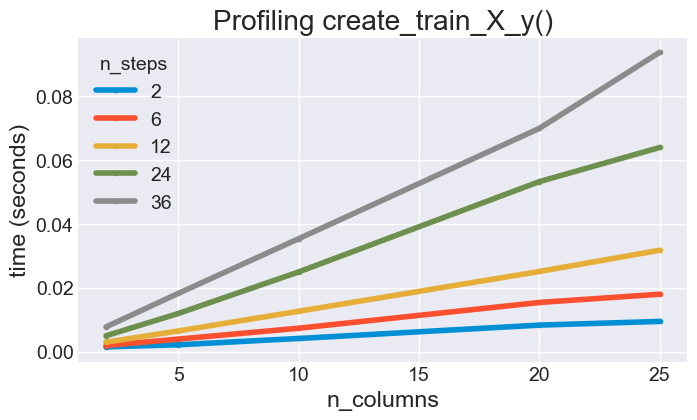

In [30]:
fig, ax = plt.subplots(figsize=(7, 4))
results.plot(ax=ax, marker='.')
ax.set_xlabel('n_columns')
ax.set_ylabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title='n_steps');

In [35]:
def exog_to_direct_new(
    exog: pd.DataFrame,
    steps: int
)-> pd.DataFrame:
    """
    """
    if not isinstance(exog, (pd.Series, pd.DataFrame)):
        raise TypeError(f"`exog` must be a pandas Series or DataFrame. Got {type(exog)}.")

    if isinstance(exog, pd.Series):
        exog = exog.to_frame()

    n_rows = len(exog)
    exog_idx = exog.index
    exog_transformed = []

    for i in range(steps):

        exog_column_transformed = exog.iloc[i : n_rows - (steps - 1 - i), ]
        exog_column_transformed.index = pd.RangeIndex(len(exog_column_transformed))
        exog_column_transformed.columns = [f"{col}_step_{i+1}" for col in exog_column_transformed.columns]

        exog_transformed.append(exog_column_transformed)

    if len(exog_transformed) > 1:
        exog_transformed = pd.concat(exog_transformed, axis=1, copy=True) # Se nota diferencia con el copy
    else:
        exog_transformed = exog_column_transformed

    exog_transformed.index = exog_idx[-len(exog_transformed):]

    return exog_transformed

In [14]:
exog = pd.DataFrame({'exog_1': pd.Series(np.arange(100, 150), dtype=float),
                     'exog_2': pd.Series(np.arange(1000, 1050), dtype=int),
                     'exog_3': pd.Categorical(range(100, 150))})
exog_len = len(exog)
exog.head(3)

,exog_1,exog_2,exog_3
0,100.0,1000,100
1,101.0,1001,101
2,102.0,1002,102


In [30]:
%%timeit -r 10 -n 10000

exog.reset_index(drop=True)

24.2 µs ± 635 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [37]:
%%timeit -r 10 -n 10000

exog.index = pd.RangeIndex(len(exog))

4.91 µs ± 154 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [36]:
exog = pd.DataFrame({'exog_1': pd.Series(np.arange(100, 150), dtype=float),
                        'exog_2': pd.Series(np.arange(1000, 1050), dtype=int),
                        'exog_3': pd.Categorical(range(100, 150))})
exog.index = pd.date_range("1990-01-01", periods=50, freq='D')
steps = [10]

exog_to_direct_new(exog=exog.iloc[:max(steps), ], steps=max(steps)).head(3)

,exog_1_step_1,exog_2_step_1,exog_3_step_1,exog_1_step_2,exog_2_step_2,exog_3_step_2,exog_1_step_3,exog_2_step_3,exog_3_step_3,exog_1_step_4,...,exog_3_step_7,exog_1_step_8,exog_2_step_8,exog_3_step_8,exog_1_step_9,exog_2_step_9,exog_3_step_9,exog_1_step_10,exog_2_step_10,exog_3_step_10
1990-01-10,100.0,1000,100,101.0,1001,101,102.0,1002,102,103.0,...,106,107.0,1007,107,108.0,1008,108,109.0,1009,109


In [25]:
# Profiling `exog_to_direct` for different length of columns
# ======================================================================================
import time 

n_columns = [2, 5, 10, 20, 25]
n_steps = [2, 6, 12, 24, 36]
results = {}

for steps in n_steps:
    execution_time = []

    for n in n_columns:
        df = pd.DataFrame(np.arange(100000).reshape(int(100000/n), n)).head(1000)
        tic = time.perf_counter()
        _ = exog_to_direct_new(exog=df, steps=steps)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results[steps] = execution_time

results = pd.DataFrame(
              data =  results,
              index = n_columns
          )

results

,2,6,12,24,36
2,0.000896,0.000690,0.002211,0.003779,0.003750
5,0.000650,0.001129,0.002663,0.002767,0.004154
10,0.000637,0.001075,0.002502,0.002994,0.004440
20,0.000416,0.001091,0.002349,0.002615,0.003959
25,0.000367,0.001120,0.002186,0.002870,0.003943


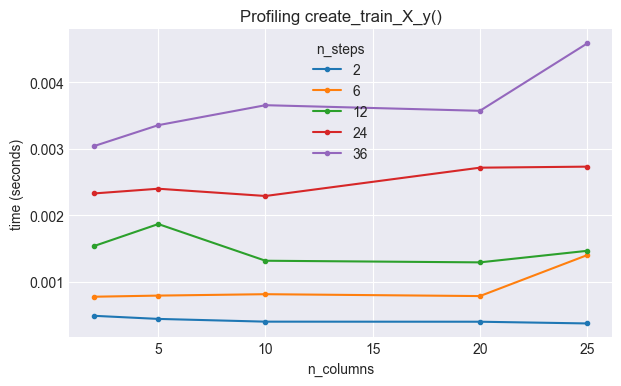

In [21]:
fig, ax = plt.subplots(figsize=(7, 4))
results.plot(ax=ax, marker='.')
ax.set_xlabel('n_columns')
ax.set_ylabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title='n_steps');